# Fish data

In [2]:
import os
import pandas as pd
import sys
from eks.utils import *
from eks.multiview_pca_smoother import *
from eks.newton_eks import *
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm
from eks.video import get_frames_from_idxs, save_video
from scipy.optimize import *
import scipy as sp

In [171]:
import numpy
import cv2
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import defaultdict
import shutil

In [4]:
labeled_new = pd.read_csv("data/mirror-fish/CollectedData_new.csv", header = [0,1,2], index_col=0)

In [5]:
labeled_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, labeled-data/20210126_Sean/img001058.png to labeled-data/20210204_Quin/img197707.png
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (rick, head_main, x)        94 non-null     float64
 1   (rick, head_main, y)        94 non-null     float64
 2   (rick, chin_base_main, x)   91 non-null     float64
 3   (rick, chin_base_main, y)   91 non-null     float64
 4   (rick, chin1_4_main, x)     90 non-null     float64
 5   (rick, chin1_4_main, y)     90 non-null     float64
 6   (rick, chin_half_main, x)   91 non-null     float64
 7   (rick, chin_half_main, y)   91 non-null     float64
 8   (rick, chin3_4_main, x)     92 non-null     float64
 9   (rick, chin3_4_main, y)     92 non-null     float64
 10  (rick, chin_tip_main, x)    92 non-null     float64
 11  (rick, chin_tip_main, y)    92 non-null     float64
 12  (rick, mid_main, x)   

KeyError: 'bodyparts'

In [29]:
labeled = pd.read_csv("data/mirror-fish/CollectedData.csv", header = [0,1,2], index_col=0)

<Axes: xlabel='scorer-bodyparts-coords'>

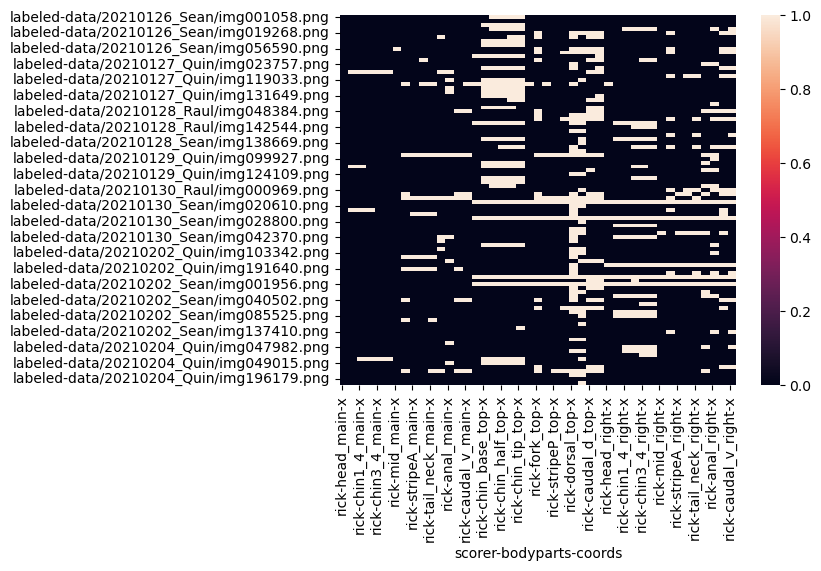

In [132]:
sns.heatmap(labeled_new.isna())

In [144]:
(1-np.sum(labeled_new.isna())/len(labeled_new))[:20]

scorer  bodyparts       coords
rick    head_main       x         1.000000
                        y         1.000000
        chin_base_main  x         0.968085
                        y         0.968085
        chin1_4_main    x         0.957447
                        y         0.957447
        chin_half_main  x         0.968085
                        y         0.968085
        chin3_4_main    x         0.978723
                        y         0.978723
        chin_tip_main   x         0.978723
                        y         0.978723
        mid_main        x         0.989362
                        y         0.989362
        fork_main       x         0.904255
                        y         0.904255
        stripeA_main    x         0.946809
                        y         0.946809
        stripeP_main    x         0.925532
                        y         0.925532
dtype: float64

In [12]:
from eks.utils import convert_lp_dlc
from eks.multiview_pca_smoother import ensemble_kalman_smoother_multi_cam


camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = [
    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]


## Plots

In [13]:
def profile_plot(baseline, pathfile, operator, name):

    fig,ax = plt.subplots(2,2,figsize=(12,10))

    #ax[0,0].plot(new.caudal_d_right[["x"]], color='black')
    ax[0,0].plot(baseline.caudal_d_right[["x"]], 'r--',label='baseline' )
    ax[0,0].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].set_ylabel("x coords")
    ax[0,0].set_title("caudal_d right")
    ax[0,0].legend(['baseline eks', 'individual models'])

    #ax[0,1].plot(new.caudal_d_right[["y"]], color='black')
    ax[0,1].plot(baseline.caudal_d_right[["y"]], 'r--',label='baseline')
    ax[0,1].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].set_title("caudal_d right")
    ax[0,1].set_ylabel("y coords")
    ax[0,1].legend(['baseline eks', 'individual models'])

    #ax[1,0].plot(new.chin_tip_right[["x"]], color='black')
    ax[1,0].plot(baseline.chin_tip_right[["x"]], 'r--',label='baseline')
    ax[1,0].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].set_title("chin_tip right")
    ax[1,0].set_ylabel("x coords")
    ax[1,0].legend(['baseline eks', 'individual models'])

    #ax[1,1].plot(new.chin_tip_right[["y"]],color='black')
    ax[1,1].plot(baseline.chin_tip_right[["y"]], 'r--',label='baseline')
    ax[1,1].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].set_title("chin_tip right")
    ax[1,1].set_ylabel("y coords")
    ax[1,1].legend(['baseline eks', 'individual models'])

    plt.suptitle("Video {}".format(name))

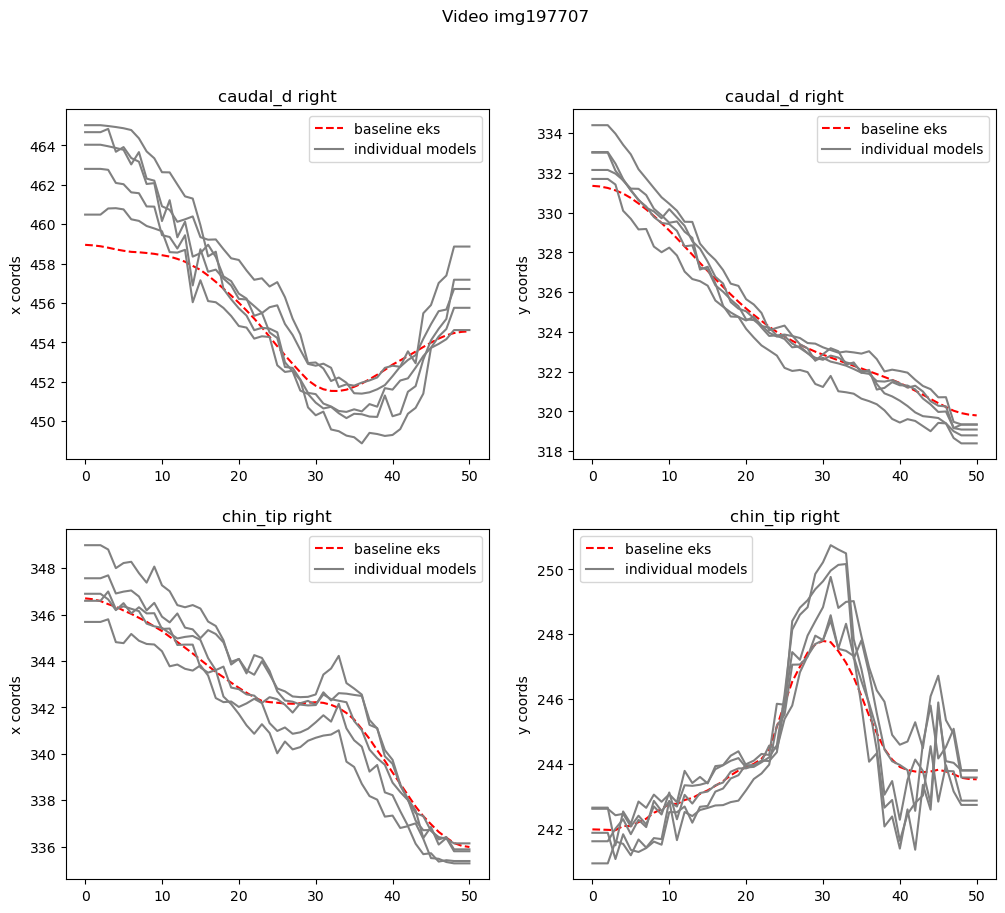

In [14]:
folder = "/eks_opti"
operator = "/20210204_Quin/"
name = "img197707"

baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[ 1, 2],index_col=0)
#new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions"+folder+operator+name, header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[0, 1, 2],index_col=0)

keypoint_names = [l[1] for l in baseline0.columns[::3]]
markers_tmp = convert_lp_dlc(baseline0, keypoint_names, model_name=tracker_name)
markers_tmp.head()
pathfile = "/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/"
profile_plot(baseline, pathfile, operator, name)

In [40]:
lab_points = labeled.loc["labeled-data"+operator+name+".png"]
lab_points

scorer  bodyparts       coords
rick    head_main       x         193.333333
                        y         253.333333
        chin_base_main  x         214.444444
                        y         232.222222
        chin1_4_main    x         217.777778
                                     ...    
        anal_right      y         309.444444
        caudal_d_right  x         453.840000
                        y         321.320000
        caudal_v_right  x         433.888889
                        y         343.333333
Name: labeled-data/20210204_Quin/img197707.png, Length: 90, dtype: float64

In [409]:
for parts in bodyparts:
    if "head" in parts:
        print(parts)

head_main
head_top
head_right


In [2019]:
markers_list_cameras[1]


[    chin_base_top_x  chin_base_top_y
 0        217.703506       128.839142
 1        217.703506       128.839142
 2        217.703506       128.839142
 3        217.793564       129.139099
 4        217.760925       129.292908
 5        218.030899       129.641129
 6        218.013840       130.020065
 7        218.085526       129.980713
 8        218.126175       130.375793
 9        218.265244       130.645630
 10       218.392578       131.055420
 11       218.552231       131.293945
 12       218.681335       131.592102
 13       218.771164       131.720352
 14       218.884476       132.162170
 15       219.005737       132.424927
 16       218.986267       132.466064
 17       219.140121       133.140472
 18       219.086258       132.872940
 19       218.955551       133.588104
 20       218.872879       133.773544
 21       218.868637       134.317139
 22       218.775940       134.651398
 23       218.432800       134.565964
 24       218.595642       135.081650
 25       21

In [545]:
bodyparts = []
m = lab_points["rick"].index
for i in range(len(lab_points["rick"])):
    if m[i][1] == 'x':
        bodyparts.append(m[i][0])
    else:
        pass

In [546]:
lab_points["rick"][bodyparts[0]]

coords
x    193.333333
y    253.333333
Name: labeled-data/20210204_Quin/img197707.png, dtype: float64

In [119]:
keys = ["_main","_top","_right"]

Text(0.5, 0.98, 'labeled img197707')

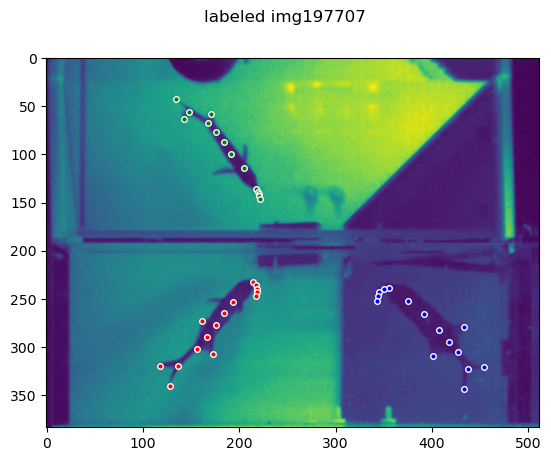

In [123]:
marker_shapes = 'o'
model_colors = ['red','green','blue']

fig,ax = plt.subplots()
for j, part in enumerate(bodyparts):
    for i, key in enumerate(keys):
        if key in part:
            ax.plot(lab_points["rick"][part][0],lab_points["rick"][part][1], marker_shapes, markeredgecolor='w', markersize=4, 
                color=model_colors[i])

image_path = "data/mirror-fish/labeled-data"
im = plt.imread(image_path+operator+name+".png")
plt.imshow(im)
plt.suptitle("labeled "+name)


In [2022]:
lab_points['rick']['head_main']

coords
x    193.333333
y    253.333333
Name: labeled-data/20210204_Quin/img197707.png, dtype: float64

In [2005]:
def plot_bodyparts(ax, data, bodyparts, marker_shape='o', label = False):
    model_colors = ['red','green','blue']

    for j, part in enumerate(bodyparts):
        for i, key in enumerate(keys):
            if key in part:
                ax.plot(data[part]["x"],data[part]["y"], marker_shape, markeredgecolor='w', markersize=4, 
                    color=model_colors[i])
    if label == True:
        image_path = "data/mirror-fish/labeled-data"
        im = plt.imread(image_path+operator+name+".png")
        plt.imshow(im)
    plt.suptitle("parts "+name)

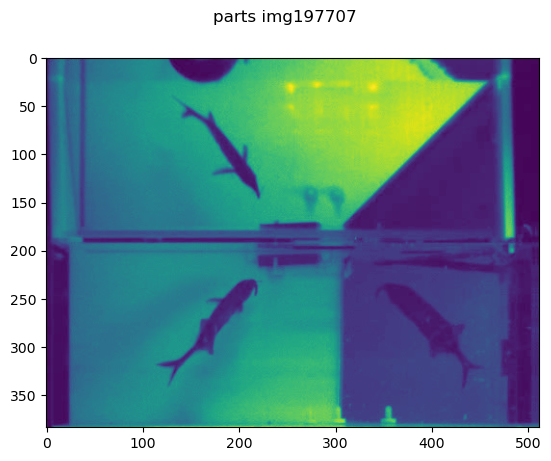

In [2006]:
fig,ax = plt.subplots()
bodypart = ["chin_base_main", "mid_main","fork_main","chin_base_top", "mid_top","fork_top","chin_base_right", "mid_right","fork_right"]
plot_bodyparts(ax, lab_points["rick"],bodypart, label=True)

Get the distance constraints: chin_base/fork, chin_base/mid_main

In [839]:
test = lab_points["rick"][["chin_base_main","chin_base_top","chin_base_right","fork_top","fork_right","fork_main"]]

In [840]:
test

bodyparts        coords
chin_base_main   x         214.444444
                 y         232.222222
chin_base_top    x         217.777778
                 y         136.111111
chin_base_right  x         355.000000
                 y         238.888889
fork_top         x         147.777778
                 y          56.111111
fork_right       x         437.840000
                 y         322.560000
fork_main        x         136.320000
                 y         320.000000
Name: labeled-data/20210204_Quin/img197707.png, dtype: float64

array([184.44444444, 265.        , 191.6       ,  99.68      ,
       391.66666667, 266.11111111])

In [867]:
lab_points["rick"][["mid_main","mid_top","mid_right"]]

bodyparts  coords
mid_main   x         184.444444
           y         265.000000
mid_top    x         191.600000
           y          99.680000
mid_right  x         391.666667
           y         266.111111
Name: labeled-data/20210204_Quin/img197707.png, dtype: float64

In [1823]:

def ensemble(markers_list, keys, mode='median'):
    """Computes ensemble median (or mean) and variance of list of DLC marker dataframes
    Args:
        markers_list: list
            List of DLC marker dataframes`
        keys: list
            List of keys in each marker dataframe
        mode: string
            Averaging mode which includes 'median' or 'mean'. 
            
    Returns:
        ensemble_preds: np.ndarray
            shape (samples, n_keypoints)
        ensemble_vars: np.ndarray
            shape (samples, n_keypoints)
        ensemble_stacks: np.ndarray
            shape (n_models, samples, n_keypoints)
        keypoints_avg_dict: dict
            keys: marker keypoints, values: shape (samples)
        keypoints_var_dict: dict
            keys: marker keypoints, values: shape (samples)
        keypoints_stack_dict: dict(dict)
            keys: model_ids, keys: marker keypoints, values: shape (samples)
    """
    ensemble_stacks = []
    ensemble_vars = []
    ensemble_preds = []
    keypoints_avg_dict = {}
    keypoints_var_dict = {}
    keypoints_stack_dict = defaultdict(dict)
    if mode == 'median':
        average_func = np.median
    elif mode == 'mean':
        average_func = np.mean
    else:
        raise ValueError(f"{mode} averaging not supported")
    for key in keys:
        stack = np.zeros((len(markers_list), markers_list[0].shape[0]))
        for k in range(len(markers_list)):
            stack[k] = markers_list[k][key]
        stack = stack.T
        avg = average_func(stack, 1)
        var = np.var(stack, 1) / len(markers_list)  # variance of the sample mean
        ensemble_preds.append(avg)
        ensemble_vars.append(var)
        ensemble_stacks.append(stack)
        keypoints_avg_dict[key] = avg
        keypoints_var_dict[key] = var
        for i, keypoints in enumerate(stack.T):
            keypoints_stack_dict[i][key] = stack.T[i]
    ensemble_preds = np.asarray(ensemble_preds).T
    ensemble_vars = np.asarray(ensemble_vars).T
    ensemble_stacks = np.asarray(ensemble_stacks).T
    return ensemble_preds, ensemble_vars, ensemble_stacks, keypoints_avg_dict, keypoints_var_dict, keypoints_stack_dict


In [871]:
chin_mid = np.sqrt(np.sum((lab_points["rick"]["chin_base_main"]-lab_points["rick"]["mid_main"])**2))
fork_mid =np.sqrt(np.sum((lab_points["rick"]["fork_main"]-lab_points["rick"]["mid_main"])**2))
chin_fork = np.sqrt(np.sum((lab_points["rick"]["fork_main"]-lab_points["rick"]["chin_base_main"])**2))
print(chin_mid, fork_mid, chin_fork)

44.43402655678863 73.08188662785312 117.50900855405936


In [872]:
np.sqrt(np.sum((lab_points["rick"]["chin_base_main"]-lab_points["rick"]["mid_main"])**2))

44.43402655678863

Text(0.5, 0.98, 'img197707')

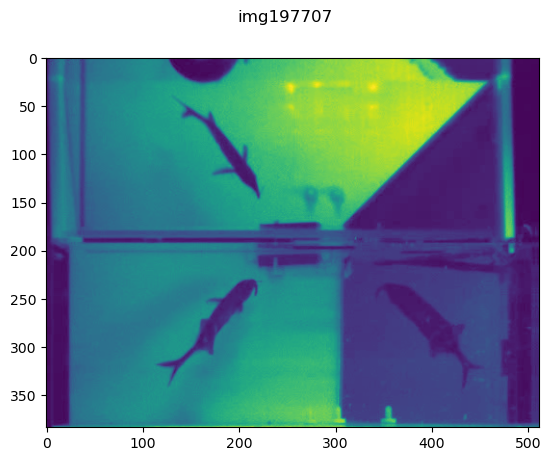

In [873]:
image_path = "data/mirror-fish/labeled-data"
im = plt.imread(image_path+operator+name+".png")
plt.imshow(im)
plt.suptitle(name)

In [874]:
def get_frames_from_idxs(cap, idxs):
    """Helper function to load video segments.
    Parameters
    ----------
    cap : cv2.VideoCapture object
    idxs : array-like
        frame indices into video
    Returns
    -------
    np.ndarray
        returned frames of shape shape (n_frames, n_channels, ypix, xpix)
    """
    is_contiguous = np.sum(np.diff(idxs)) == (len(idxs) - 1)
    n_frames = len(idxs)
    for fr, i in enumerate(idxs):
        if fr == 0 or not is_contiguous:
            cap.set(1, i)
        ret, frame = cap.read()
        if ret:
            if fr == 0:
                height, width, _ = frame.shape
                frames = np.zeros((n_frames, 1, height, width), dtype='uint8')
            frames[fr, 0, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            return frames
        else:
            print(
                'warning! reached end of video; returning blank frames for remainder of ' +
                'requested indices')
            break
    


In [879]:
baseline.iloc[n]["chin_base_main"]

coords
x             212.905858
y             232.839523
likelihood      1.000000
Name: 49, dtype: float64

In [881]:
eps = 10
def distance(a,b):
    return np.sqrt(np.sum((a-b)**2))
def investigate_constraint_cmf(bodypart, plot=False):
    new_chin_mid = []
    new_chin_fork = []
    new_mid_fork= []
    if plot:
        for n in range(50):
            fig,ax = plt.subplots()
            frame = get_frames_from_idxs(cap, [n])[0][0]
            plot_bodyparts(ax,baseline.iloc[n],bodypart)
            plot_bodyparts(ax,lab_points["rick"],bodypart,marker_shape='x')
            new_chin_mid.append(distance(baseline.iloc[n]["chin_base_main"],baseline.iloc[n]["mid_main"]))
            new_chin_fork.append(distance(baseline.iloc[n]["chin_base_main"],baseline.iloc[n]["fork_main"]))
            new_mid_fork.append(distance(baseline.iloc[n]["fork_main"],baseline.iloc[n]["mid_main"]))
            ax.imshow(frame)
        plt.show()
    else:
        for n in range(50):
            new_chin_mid.append(distance(baseline.iloc[n]["chin_base_main"],baseline.iloc[n]["mid_main"]))
            new_chin_fork.append(distance(baseline.iloc[n]["chin_base_main"],baseline.iloc[n]["fork_main"]))
            new_mid_fork.append(distance(baseline.iloc[n]["fork_main"],baseline.iloc[n]["mid_main"])) 
    
    new_distances = pd.DataFrame(data={'chin_mid':new_chin_mid,'chin_fork':new_chin_fork, 'mid_fork':new_mid_fork})
    print(distance(np.mean(new_chin_mid),chin_mid),distance(np.mean(new_chin_fork),chin_fork),distance(np.mean(new_mid_fork),fork_mid)) 
    return new_distances

In [882]:
new_distances = investigate_constraint_cmf(bodypart)

2.751162946341843 3.00511632443704 0.1785454239895472


In [885]:
chin_mid, chin_fork, fork_mid

(44.43402655678863, 117.50900855405936, 73.08188662785312)

In [1168]:
np.sum(new_distances.chin_mid>chin_mid)/len(new_distances),np.sum(new_distances.chin_fork>chin_fork)/len(new_distances),np.sum(new_distances.mid_fork>fork_mid)/len(new_distances)

(0.0, 0.3, 0.58)

<Axes: >

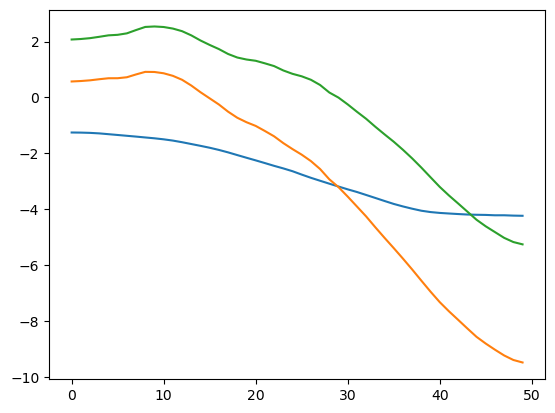

In [887]:
(new_distances.chin_mid - chin_mid).plot()
(new_distances.chin_fork - chin_fork).plot()
(new_distances.mid_fork - fork_mid).plot()

## Explore constraints

In [2020]:
# -----------------------
# funcs for kalman paw
# -----------------------
def remove_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] - camera_mean
    return scaled_ensemble_stacks


def add_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] + camera_mean
    return scaled_ensemble_stacks


def pca(S, n_comps):
    pca_ = PCA(n_components=n_comps)
    return pca_.fit(S), pca_.explained_variance_ratio_



def ensemble_kalman_smoother_multi_cam(
        markers_list_cameras, keypoint_ensemble, smooth_param, quantile_keep_pca, camera_names,kalman=False):
# --------------------------------------------------------------
# interpolate right cam markers to left cam timestamps
# --------------------------------------------------------------
    num_cameras = len(camera_names)
    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)

    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)

    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []
    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    good_cam_ensemble_vars = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])
        good_cam_ensemble_vars.append(cam_ensemble_vars[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    good_ensemble_vars = np.hstack(good_cam_ensemble_vars)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())

    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)

    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    ## PCA 
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)

    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    good_ensemble_pcs = ensemble_pcs[good_frames]
    sns.heatmap(ensemble_pca.components_)
    plt.show()
    y_obs = scaled_ensemble_preds
    # print("input",y_obs.shape)
    
    #compute center of mass
    #latent variables (observed)
    if kalman:
        good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca


        ##### Set values for kalman filter #####
        m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
        S0 =  np.asarray([[np.var(good_z_t_obs[:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

        A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
        # Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????
        d_t = good_z_t_obs[1:] - good_z_t_obs[:-1]

        Q = smooth_param*np.cov(d_t.T)

        C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
        R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance


        print(f"filtering {keypoint_ensemble}...")
        mf, Vf, S = filtering_pass(y_obs, m0, S0, C, R, A, Q, ensemble_vars)
        print(S.shape)
        print("done filtering")
        y_m_filt = np.dot(C, mf.T).T
        y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

        # Do the smoothing step
        print(f"smoothing {keypoint_ensemble}...")
        ms, Vs, _ = smooth_backward(y_obs, mf, Vf, S, A, Q, C)
        print("done smoothing")

        # Smoothed posterior over y
        y_m_smooth = np.dot(C, ms.T).T
        y_v_smooth = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)

        pdindex = make_dlc_pandas_index([keypoint_ensemble])
        camera_indices = []
        for camera in range(num_cameras):
            camera_indices.append([camera*2, camera*2+1])
    else:
        ms = [] 
    camera_dfs = {}
    # for camera, camera_name in enumerate(camera_names):
    #     var = np.empty(y_m_smooth.T[camera_indices[camera][0]].shape)
    #     var[:] = np.nan
    #     pred_arr = np.vstack([
    #         y_m_smooth.T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
    #         y_m_smooth.T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
    #         var,
    #     ]).T
    #     camera_dfs[camera_name + '_df'] = pd.DataFrame(pred_arr, columns=pdindex)

    return ms, ensemble_pca, ensemble_ex_var, camera_dfs



Modify eks code

Take PCA on all bodyparts combined.

In [1938]:
def scale_ensemble_keypoints_PCA(keypoint_ensemble_list, camera_names,quantile_keep_pca, plot=False):
    markers_dict = {}
    markers_var_dict = {}
    num_keys = len(keypoint_ensemble_list)
    #compute ensemble median for each camera
    num_cameras = len(camera_names)
    for keypoint_ensemble in keypoint_ensemble_list:
        markers_list_cameras = [[] for i in range(num_cameras)]
        for m in markers_list:
            for camera in range(num_cameras):
                markers_list_cameras[camera].append(
                    m[[key for key in m.keys() 
                       if camera_names[camera] in key 
                       and 'likelihood' not in key 
                       and keypoint_ensemble in key]
                     ]
                )

        markers_list_stacked_interp = []
        markers_list_interp = [[] for i in range(num_cameras)]
        for model_id in range(len(markers_list_cameras[0])):
            bl_markers_curr = []
            camera_markers_curr = [[] for i in range(num_cameras)]
            for i in range(markers_list_cameras[0][0].shape[0]):
                curr_markers = []
                for camera in range(num_cameras):
                    markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                    camera_markers_curr[camera].append(markers)
                    curr_markers.append(markers)
                bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
            markers_list_stacked_interp.append(bl_markers_curr)
            for camera in range(num_cameras):
                markers_list_interp[camera].append(camera_markers_curr[camera])
        markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
        markers_list_interp = np.asarray(markers_list_interp)
        cam_ensemble_preds = []
        cam_ensemble_vars = []
        cam_ensemble_stacks = []
        cam_keypoints_mean_dict = []
        cam_keypoints_var_dict = []
        cam_keypoints_stack_dict = []
        keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
        for k in range(len(markers_list_interp[0])):
            markers_list_cams = [[] for i in range(num_cameras)]
            for camera in range(num_cameras):
                markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
                markers_list_cams[camera].append(markers_cam)

            for camera in range(num_cameras):
                cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
                cam_ensemble_preds.append(cam_ensemble_preds_curr)
                cam_ensemble_vars.append(cam_ensemble_vars_curr)
                cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
                cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
                cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
                cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)
        
        markers_dict[keypoint_ensemble] = cam_ensemble_preds
        markers_var_dict[keypoint_ensemble] = cam_ensemble_vars
        if plot:
            test = markers_dict[keypoint_ensemble]
            # print(len(test[0]))
            plt.imshow(im)
            plt.scatter(test[1][:,0], test[1][:,1], color='green')
            plt.scatter(test[0][:,0], test[0][:,1], color='blue', alpha=0.7)
            plt.scatter(test[2][:,0], test[2][:,1], color='red', alpha=0.7)
            plt.show()
    n = len(keypoint_ensemble_list)

    #filter by low ensemble variances
    hstacked_vars = np.concatenate([np.hstack(markers_var_dict[keypoint_ensemble]) for keypoint_ensemble in  keypoint_ensemble_list])
    hstacked_preds =  np.concatenate([np.hstack(markers_dict[keypoint_ensemble]) for keypoint_ensemble in  keypoint_ensemble_list])
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    # Get good predictions and variances
    good_ensemble_preds = []
    good_ensemble_vars = []
    good_ensemble_preds = hstacked_preds[good_frames,:].reshape((n*hstacked_preds[good_frames,:].shape[0], hstacked_preds[good_frames,:].shape[1]//n))
    good_ensemble_vars = hstacked_vars[good_frames,:].reshape((n*hstacked_vars[good_frames,:].shape[0], hstacked_vars[good_frames,:].shape[1]//n))

    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())
    # Scale and center for PCA
    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_preds = ensemble_preds.reshape((n*ensemble_preds.shape[0], ensemble_preds.shape[1]//n))
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_vars = ensemble_vars.reshape((n*ensemble_vars.shape[0], ensemble_vars.shape[1]//n))
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)
    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    print(np.shape(scaled_ensemble_preds))
    # Get PCA components
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    print(np.shape(ensemble_pcs))
    good_ensemble_pcs = ensemble_pcs[good_frames]
    

    return scaled_ensemble_preds, ensemble_pcs, ensemble_pca, ensemble_vars


In [2004]:
#markers_list

In [1956]:
keypoint_ensemble_list = ['mid','fork','chin_base']

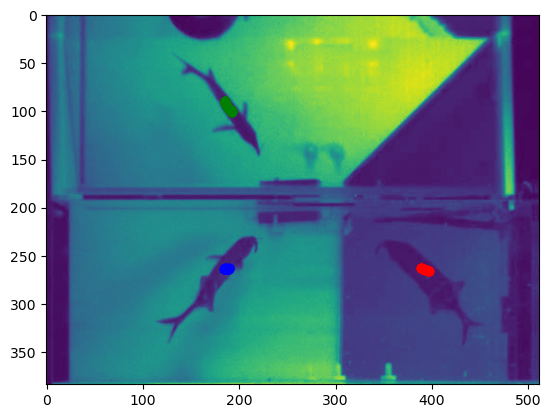

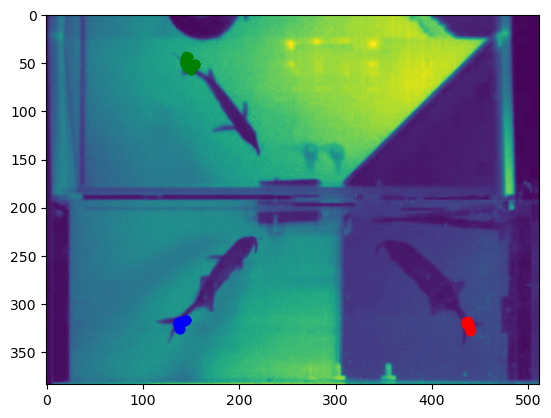

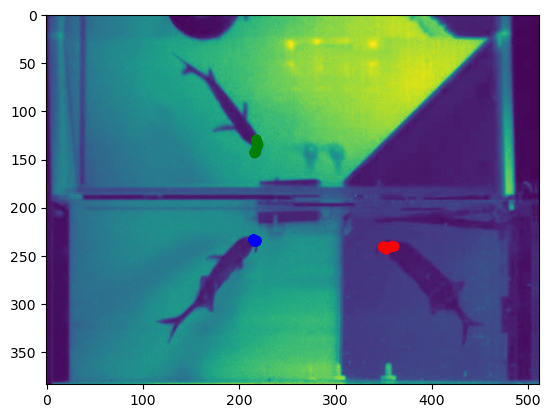

markers (3, 51, 2)
good (153, 6)
ensemble (3, 204, 2)


IndexError: index 2 is out of bounds for axis 1 with size 2

In [1997]:
markers_dict = {}
markers_var_dict = {}
num_keys = len(keypoint_ensemble_list)
#compute ensemble median for each camera
num_cameras = len(camera_names)
       
for keypoint_ensemble in keypoint_ensemble_list:
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
            
    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)
    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']

    for k in range(len(markers_list_interp[0])):
        markers_list_cams = [[] for i in range(num_cameras)]
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []

    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)


    markers_dict[keypoint_ensemble] = cam_ensemble_preds
    markers_var_dict[keypoint_ensemble] = cam_ensemble_vars
    
    test = markers_dict[keypoint_ensemble]
 
    plt.imshow(im)
    plt.scatter(test[1][:,0], test[1][:,1], color='green')
    plt.scatter(test[0][:,0], test[0][:,1], color='blue', alpha=0.7)
    plt.scatter(test[2][:,0], test[2][:,1], color='red', alpha=0.7)
    plt.show()
n = len(keypoint_ensemble_list)

print('markers',np.shape(markers_dict['mid']))


#filter by low ensemble variances
hstacked_vars = np.concatenate([np.hstack(markers_var_dict[keypoint_ensemble]) for keypoint_ensemble in  keypoint_ensemble_list])
hstacked_preds =  np.concatenate([np.hstack(markers_dict[keypoint_ensemble]) for keypoint_ensemble in  keypoint_ensemble_list])

max_vars = np.max(hstacked_vars,1)
quantile_keep = quantile_keep_pca
good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

# Get good predictions and variances
good_ensemble_preds = []
good_ensemble_vars = []
good_ensemble_preds = hstacked_preds[good_frames,:]
good_ensemble_vars = hstacked_vars[good_frames,:]
print("good",hstacked_preds[good_frames,:].shape)

means_camera = []
for i in range(good_ensemble_preds.shape[1]):
    means_camera.append(good_ensemble_preds[:,i].mean())
    
# Scale and center for PCA
ensemble_preds = np.empty(np.shape(markers_dict[keypoint_ensemble_list[0]]))
ensemble_vars = np.empty(np.shape(markers_var_dict[keypoint_ensemble_list[0]]))
for keypoint_ensemble in keypoint_ensemble_list:
    ensemble_preds = np.hstack((ensemble_preds, markers_dict[keypoint_ensemble]))
    ensemble_vars = np.hstack((ensemble_vars, markers_var_dict[keypoint_ensemble]))
ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
print('ensemble',np.shape(ensemble_preds))
scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)
good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
scaled_ensemble_preds = remove_camera_means(ensemble_preds[:,:], means_camera)[0]

# Get PCA components
ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)
ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)

good_ensemble_pcs = ensemble_pcs[good_frames]


In [2000]:
204/51

4.0

In [1980]:
list(markers_dict.items())[0][1]

[array([[183.94567871, 264.0982666 ],
        [183.94567871, 264.0982666 ],
        [183.94567871, 264.0982666 ],
        [184.17402649, 263.99502563],
        [184.32446289, 263.82226562],
        [184.67321777, 263.56463623],
        [184.67053223, 263.58288574],
        [184.90765381, 263.52783203],
        [185.04673767, 263.41488647],
        [185.31507874, 263.35308838],
        [185.33630371, 263.26849365],
        [185.53895569, 263.0592041 ],
        [185.58598328, 262.95809937],
        [185.67253113, 262.81167603],
        [185.5092926 , 262.81454468],
        [185.52275085, 263.06005859],
        [185.70436096, 263.02627563],
        [186.04536438, 263.32611084],
        [186.28862   , 263.40066528],
        [186.43577576, 263.456604  ],
        [186.50810242, 263.56747437],
        [186.67329407, 263.55328369],
        [186.5771637 , 263.54989624],
        [186.63946533, 263.58007812],
        [186.52302551, 263.69494629],
        [186.52325439, 263.93585205],
        [186

In [1942]:
ensemble_stacks

array([[[138.2069397 , 326.41583252, 146.18635559,  43.34288025,
         440.04516602, 328.18600464],
        [138.2069397 , 326.41583252, 146.18635559,  43.34288025,
         440.04516602, 328.18600464],
        [138.2069397 , 326.41583252, 146.18635559,  43.34288025,
         440.04516602, 328.18600464],
        [137.81196594, 325.56307983, 145.36323547,  43.87495041,
         439.89590454, 328.2472229 ],
        [137.44706726, 325.11260986, 144.81634521,  42.79855728,
         439.65328979, 327.58087158],
        [137.48825073, 324.42248535, 144.12202454,  44.45907211,
         439.8453064 , 327.34802246],
        [137.04588318, 324.01013184, 143.82641602,  44.87371826,
         439.61157227, 326.71896362],
        [136.84625244, 323.54455566, 143.92927551,  45.78491592,
         439.57901001, 326.52056885],
        [137.01005554, 322.91769409, 143.83670044,  47.25045776,
         439.52822876, 326.02606201],
        [136.94711304, 322.56912231, 143.41369629,  47.44268417,
        

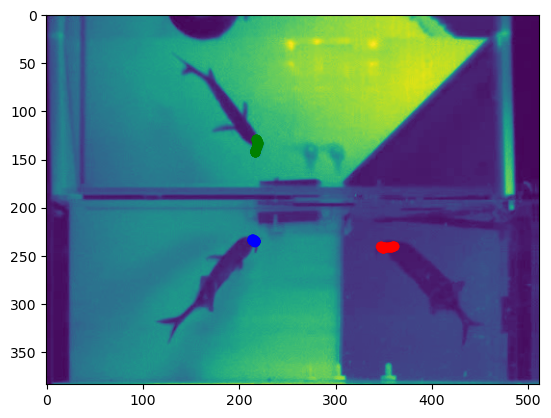

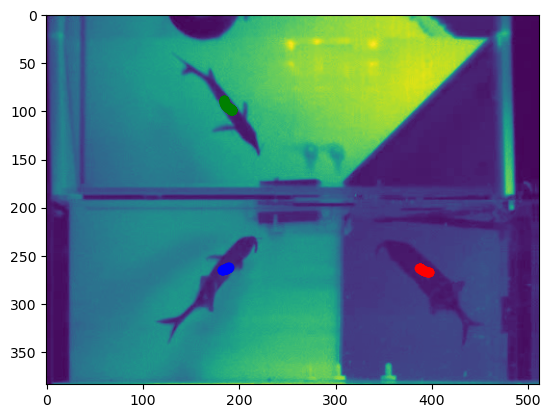

(102, 15)
(102, 3)


In [1954]:
keypoint_ensemble_list = ["chin_base","mid"]
scaled_ensemble_preds, ensemble_pcs, ensemble_pca, ensemble_vars = scale_ensemble_keypoints_PCA(keypoint_ensemble_list, camera_names,quantile_keep_pca, plot=True)

In [1944]:
scaled_ensemble_preds

array([[ 23.90383799, -46.2269982 , -43.99585148, ...,  24.34718147,
        -46.98443222, -41.41235785],
       [-69.04753988,  88.30937875,  40.38279537, ..., -68.53268608,
         86.38211441,  38.17925592],
       [ 23.90383799, -46.2269982 , -43.99585148, ...,  24.34718147,
        -46.98443222, -41.41235785],
       ...,
       [-58.37118642,  78.73262705,  35.9038525 , ..., -59.25373253,
         77.67831802,  34.75045343],
       [ 28.96305735, -48.76651846, -35.75525089, ...,  28.29986396,
        -47.4819603 , -34.76607184],
       [-58.37118642,  78.73262705,  35.9038525 , ..., -59.25373253,
         77.67831802,  34.75045343]])

In [1945]:
y = {}
z = {}
n = len(keypoint_ensemble_list)

for i, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    # observed
    y[keypoint_ensemble] = scaled_ensemble_preds[i*n:(i+1)*n,]
    # latent
    z[keypoint_ensemble] = ensemble_pcs[i*n:(i+1)*n,]
    ##### Set values for kalman filter #####
    
m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean

A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
# Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????


C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance

ms = {}
Vs = {}
y_m_smooth = {}
y_v_smooth = {}

for i, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    S0 =  np.asarray([[np.var(z[keypoint_ensemble][:,0]), 0.0, 0.0], [0.0, np.var(z[keypoint_ensemble][:,1]), 0.0], [0.0, 0.0, np.var(z[keypoint_ensemble][:,2])]]) # diagonal: var

    d_t = z[keypoint_ensemble][1:] - z[keypoint_ensemble][:-1]
    Q = smooth_param*np.cov(d_t.T)
    print(f"filtering {keypoint_ensemble}...")
    mf, Vf, S = filtering_pass(y[keypoint_ensemble], m0, S0, C, R, A, Q, ensemble_vars[i*n:(i+1)*n,])
    print("done filtering")
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    print(f"smoothing {keypoint_ensemble}...")
    ms[keypoint_ensemble], Vs[keypoint_ensemble], _ = smooth_backward(y[keypoint_ensemble], mf, Vf, S, A, Q, C)
    print("done smoothing")

    # Smoothed posterior over y
    y_m_smooth[keypoint_ensemble] = np.dot(C, ms[keypoint_ensemble].T).T
    y_v_smooth[keypoint_ensemble] = np.swapaxes(np.dot(C, np.dot(Vs[keypoint_ensemble], C.T)), 0, 1)


filtering chin_base...
done filtering
smoothing chin_base...
done smoothing
filtering mid...
done filtering
smoothing mid...
done smoothing


/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3724110125.py:30: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/clairehe/Applications/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/Users/clairehe/Applications/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply



In [1873]:
y['chin_base']-y['mid']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1354]:
##### Set values for kalman filter #####
m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean

A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
# Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????


C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance

ms = {}
Vs = {}
y_m_smooth = {}
y_v_smooth = {}

for keypoint_ensemble in keypoint_ensemble_list:
    S0 =  np.asarray([[np.var(z[keypoint_ensemble][:,0]), 0.0, 0.0], [0.0, np.var(z[keypoint_ensemble][:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

    d_t = z[keypoint_ensemble][1:] - z[keypoint_ensemble][:-1]
    Q = smooth_param*np.cov(d_t.T)
    print(f"filtering {keypoint_ensemble}...")
    mf, Vf, S = filtering_pass(y[keypoint_ensemble], m0, S0, C, R, A, Q, ensemble_vars)
    print(S.shape)
    print("done filtering")
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    print(f"smoothing {keypoint_ensemble}...")
    ms[keypoint_ensemble], Vs[keypoint_ensemble], _ = smooth_backward(y[keypoint_ensemble], mf, Vf, S, A, Q, C)
    print("done smoothing")

    # Smoothed posterior over y
    y_m_smooth[keypoint_ensemble] = np.dot(C, ms[keypoint_ensemble].T).T
    y_v_smooth[keypoint_ensemble] = np.swapaxes(np.dot(C, np.dot(Vs[keypoint_ensemble], C.T)), 0, 1)


filtering fork...


ValueError: operands could not be broadcast together with shapes (3,3) (51,51) 

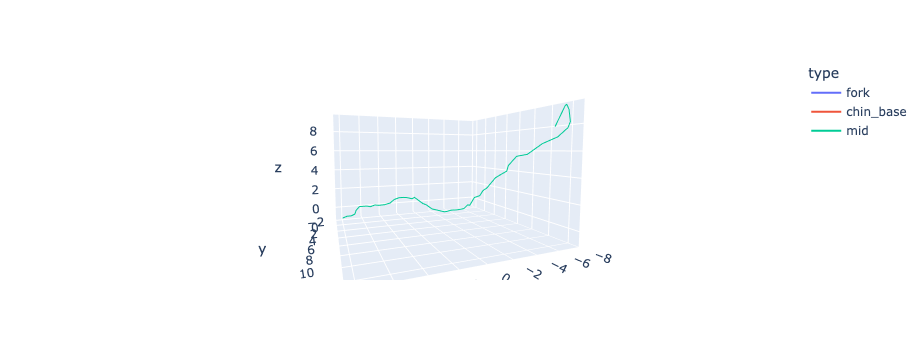

In [1277]:
data = pd.DataFrame({"x":np.concatenate([ms["fork"][:,0],ms["chin_base"][:,0],ms["mid"][:,0]]),"y": np.concatenate([ms["fork"][:,1],ms["chin_base"][:,1],ms["mid"][:,1]]),
                     "z": np.concatenate([ms["fork"][:,2],ms["chin_base"][:,2],ms["mid"][:,2]]),
                     "type":["fork" for i in range(len(ms["fork"]))]+["chin_base" for i in range(len(ms["chin_base"]))]+["mid" for i in range(len(ms["mid"]))]})
fig = px.line_3d(data, x='x', y='y', z='z', color='type')
fig.show()

In [1249]:
ms["fork"]

array([[-6.99131634, 11.32371951,  7.85856755],
       [-7.22965175, 11.97363013,  9.34563307],
       [-7.25227715, 12.09701721,  9.4416467 ],
       [-7.39387263, 12.1904565 ,  9.05942725],
       [-7.2459902 , 12.47919044,  8.13731855],
       [-7.46288996, 12.08796465,  7.72984369],
       [-7.3606333 , 11.26151306,  7.08868158],
       [-7.4161313 ,  9.61831573,  6.60216024],
       [-7.53399039,  7.71594506,  5.68680653],
       [-7.34348683,  6.47589519,  5.48395849],
       [-7.26347884,  5.36939736,  4.55852232],
       [-7.18348929,  5.23309635,  3.99359159],
       [-6.87218754,  4.25305493,  3.42276398],
       [-6.71345787,  3.98164409,  3.2094759 ],
       [-6.02662651,  3.51198974,  2.14669089],
       [-5.88507429,  2.99305093,  1.80695488],
       [-5.66530637,  2.73198016,  1.24742214],
       [-5.2613923 ,  2.27498712,  0.98176426],
       [-4.86177296,  2.27450128,  0.39714248],
       [-4.97841119,  1.79089777,  0.06864413],
       [-4.87789523,  1.52777105,  0.080

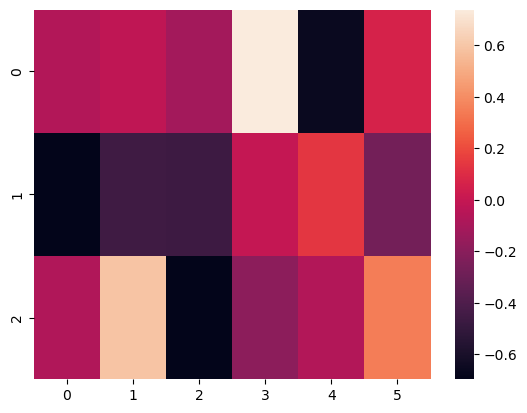

filtering chin_base...
(51, 3, 3)
done filtering
smoothing chin_base...
done smoothing


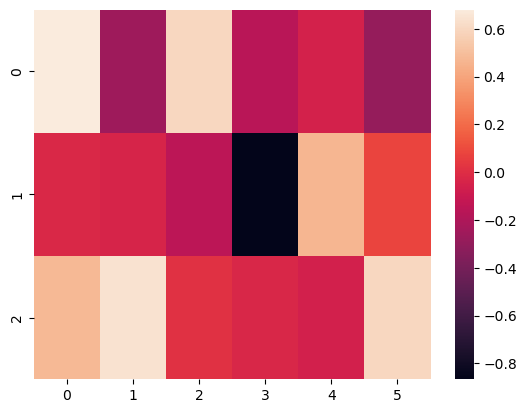

filtering fork...
(51, 3, 3)
done filtering
smoothing fork...
done smoothing


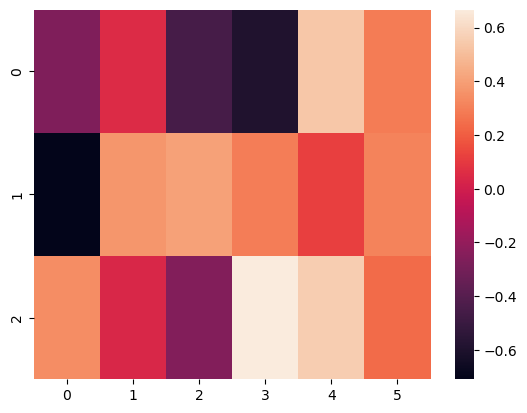

filtering mid...
(51, 3, 3)
done filtering
smoothing mid...
done smoothing


In [1358]:
session = '20210204_Quin'

camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = ['chin_base','fork', 'mid']
    #'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    #'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
    #]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_outputs/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]
frame = "img197707.csv"
# extract all markers
markers_list = []
for model_dir in model_dirs:
    csv_file = os.path.join(model_dir, session, frame)
    df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
    keypoint_names = [l[1] for l in df_tmp.columns[::3]]
    markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
    markers_list.append(markers_tmp)
# make empty dataframe to write results into
df_eks = df_tmp.copy()
for col in df_eks.columns:
    if col[-1] == 'likelihood':
        df_eks[col].values[:] = 1.0
    else:
        df_eks[col].values[:] = np.nan
# fit kalman on a keypoint-by-keypoint basis
ms = {}
ensemble_pca = {}
for keypoint_ensemble in keypoint_ensemble_list:
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    ms[keypoint_ensemble], ensemble_pca[keypoint_ensemble], ensemble_ex_var, camera_dfs = ensemble_kalman_smoother_multi_cam(
        markers_list_cameras=markers_list_cameras, 
        keypoint_ensemble=keypoint_ensemble, 
        smooth_param=0.01,
        quantile_keep_pca=50, 
        camera_names=camera_names,kalman=True
    )


In [1029]:
keypoint_ensemble = 'chin_base'
def get_pca_from_part(keypoint_ensemble, camera_names, quantile_keep_pca = 50, kalman=False):
    num_cameras = len(camera_names)
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    ms, ensemble_pca, ensemble_ex_var, camera_dfs = ensemble_kalman_smoother_multi_cam(
        markers_list_cameras=markers_list_cameras, 
        keypoint_ensemble=keypoint_ensemble, 
        smooth_param=0.01,
        quantile_keep_pca = quantile_keep_pca, 
        camera_names = camera_names, kalman=kalman)
    
    return ms, ensemble_pca, ensemble_ex_var, camera_dfs
ms_chin, ensemble_pca_chin, ensemble_ex_var_chin, camera_dfs= get_pca_from_part('chin_base', camera_names, kalman=True)

filtering chin_base...
done filtering
smoothing chin_base...
done smoothing


In [1030]:
ms_mid, ensemble_pca_mid, ensemble_ex_var_mid, camera_dfs = get_pca_from_part('mid', camera_names, kalman=True)

filtering mid...
done filtering
smoothing mid...
done smoothing


In [1031]:
ms_fork, ensemble_pca_fork, ensemble_ex_var_fork, camera_dfs = get_pca_from_part('fork', camera_names,kalman=True)

filtering fork...
done filtering
smoothing fork...
done smoothing


In [1032]:
ms_head, _, _, _ = get_pca_from_part('head', camera_names, kalman=True)

filtering head...
done filtering
smoothing head...
done smoothing


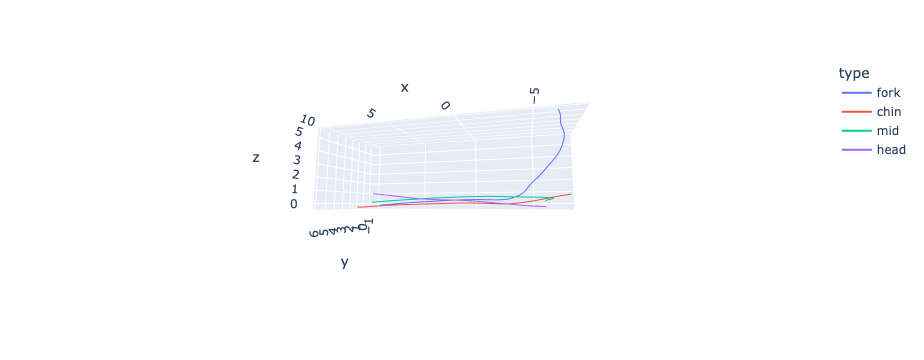

In [1270]:
import plotly.express as px
data = pd.DataFrame({"x":np.concatenate([ms_fork[:,0],ms_chin[:,0],ms_mid[:,0],ms_head[:,0]]),"y":np.concatenate([ms_fork[:,1],ms_chin[:,1],ms_mid[:,1],ms_head[:,1]]),"z":np.concatenate([ms_fork[:,2],ms_chin[:,2], ms_mid[:,2], ms_head[:,2]]), "type":["fork" for i in range(51)]+["chin" for i in range(51)]+["mid" for i in range(51)]+["head" for i in range(51)]})
fig = px.line_3d(data, x='x', y='y', z='z', color='type')
fig.show()

In [1187]:
np.linalg.norm(ms_fork)

46.12533836055524

For $t$ frame, $j,k$ bodyparts, want $\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - L_{j,k})^2$ for limb loss. 
Define $L_{j,k}$ from labeled dataset with $\tilde{y}$, use PCA to get $B_j$ and $B_k$ where $q_{t,j} = B_j \tilde{y}_{t,j}$, $q_{t,k}= B_k \tilde{y}_{t,k}$ from PCA and $L_{j,k} = ||B_j^T \tilde{y}_{t,j}-B_k^T \tilde{y}_{t,k}||_2$ then in EKS limb loss would be $\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - L_{j,k})^2 =\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - ||B_j^T \tilde{y}_{t,j}-B_k^T \tilde{y}_{t,k}||_2)^2 $

In [1423]:
labeled_markers = []
part = ['fork_main', 'fork_right', 'fork_top']
for i in range(len(part)):
    data = pd.DataFrame(lab_points["rick"][[part[i]]]).T.reset_index(drop=True)
    data.columns=[col[0] + "_" + col[1] for col in data.columns]
    labeled_markers.append([data])

Get the observation from labeled set.

In [1424]:
labeled_markers = []
for part in bodyparts:
    if 'fork' in part:
        labeled_markers.append(lab_points["rick"][part].tolist())
labeled_markers = np.asarray(labeled_markers).flatten()

Remove camera means

In [1036]:
def get_means_from_multicam(keypoint_ensemble, camera_names, quantile_keep_pca = 50):
    num_cameras = len(camera_names)
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )

    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                #print("camera",markers_list_cameras,camera,model_id)
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)

    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)
    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []

    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())
    return means_camera
#means_camera = get_means_from_multicam('fork', camera_names, quantile_keep_pca = 50)

In [1425]:
def get_labeled_latent(keypoint_ensemble, camera_names, quantile_keep_pca = 50):
    means_camera = get_means_from_multicam(keypoint_ensemble=keypoint_ensemble, camera_names=camera_names, quantile_keep_pca = 50)
    labeled_markers = []
    for part in bodyparts:
        if keypoint_ensemble in part:
            labeled_markers.append(lab_points["rick"][part].tolist())
            #print(labeled_markers)
    labeled_markers = np.asarray(labeled_markers).flatten()
    y_lab = labeled_markers - means_camera
    
    _, ensemble_pca, _, _ = get_pca_from_part(keypoint_ensemble=keypoint_ensemble, camera_names=camera_names, quantile_keep_pca=50)
    
    return labeled_markers,  np.dot(y_lab, ensemble_pca.components_.T)

In [1426]:
distance(y_chin, y_fork)

197.41248067416066

In [1427]:
get_means_from_multicam('head', camera_names, quantile_keep_pca = 50)

[194.86138622577374,
 249.1334962111253,
 201.97696509728064,
 111.15999133770282,
 378.9821577805739,
 250.10140404334436]

### Checks
camera: "main","top","right"

order: x, y 

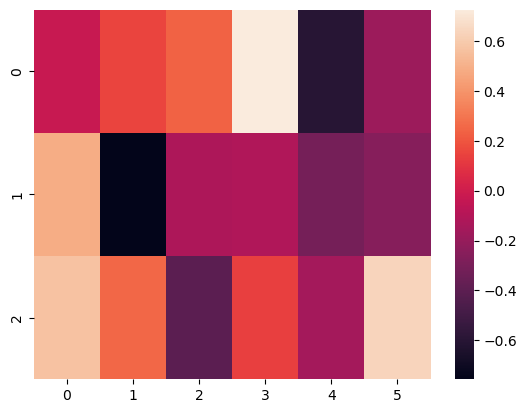

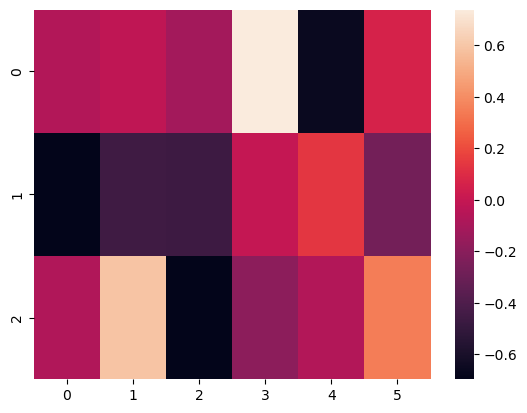

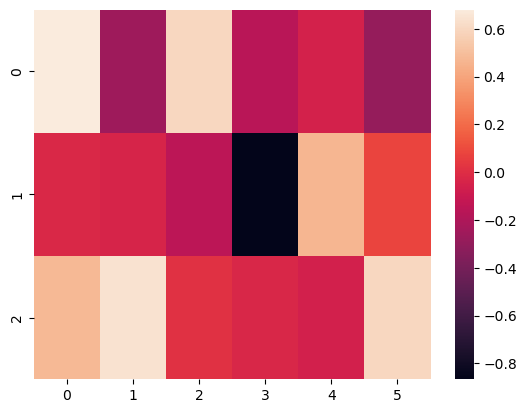

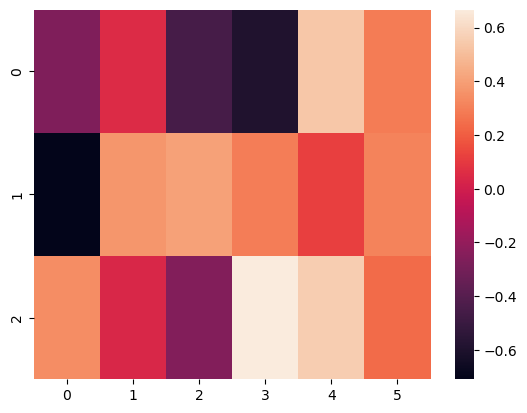

In [1428]:
y_head, q_head = get_labeled_latent("head", camera_names, quantile_keep_pca = 50)
y_chin, q_chin = get_labeled_latent("chin_base", camera_names, quantile_keep_pca = 50)
y_fork, q_fork = get_labeled_latent("fork", camera_names, quantile_keep_pca = 50)
y_mid, q_mid = get_labeled_latent("mid", camera_names, quantile_keep_pca = 50)

In [1429]:
y_chin

array([214.44444444, 232.22222222, 217.77777778, 136.11111111,
       355.        , 238.88888889])

In [1430]:
print("main",chin_mid, fork_mid, chin_fork)

main 44.43402655678863 73.08188662785312 117.50900855405936


In [1433]:
def gradient_add(q_n, q_k, l, lambda_loss = 0.1):
    return lambda_loss* q_n*(1-l/np.linalg.norm(q_n - q_k,2))

In [1158]:
n = 2
k = 1
y_n, q_n = get_labeled_latent(keypoint_ensemble_list[0], camera_names, quantile_keep_pca = 50)
y_k, q_k = get_labeled_latent(keypoint_ensemble_list[1], camera_names, quantile_keep_pca = 50)
l = L[n][k]
g = gradient_add(q_n, q_k, l, lambda_loss = 0.1)
print(g)

[ 0.04351015  0.05480598 -0.06581112]


Added term for gradient and hessian:
- Gradient $\lambda \sum_{t, j\neq k} q_{tj} \bigg(1-\frac{L_{jk}}{||q_{tj}-q_{tk}||_2}\bigg)$
- Hessian diagonal term $\lambda \sum_{t, j\neq k} \bigg\{ \big( 1- \frac{L_{jk}}{||q_{tk}-q_{tj}||_2} \big) + \frac{||q_{tj}||_2^2 L_{jk}}{||q_{tk}-q_{tj}||_2^3} \bigg\}$ 
- Hessian covariance term $- \lambda \sum_{t, j\neq k} \frac{q_{tk}q_{tj}L_{jk}}{||q_{tk}-q_{tj}||_2^3}$.

In [1152]:
def hessian_diag_add(q_n, q_k, l, lambda_loss = 0.1):
    return (1-l/np.linalg.norm(q_n-q_k,2))+l*np.linalg.norm(q_n,2)**2/np.linalg.norm(q_n-q_k,2)**3

In [1159]:
hessian_diag_add(q_n, q_k, l, lambda_loss = 0.1)

0.45267536708283423

In [1181]:
def hessian_cov_add(q_n, q_k, l, lambda_loss= 0.1):
    return - q_n @ q_k *l/np.linalg.norm(q_n-q_k,2)**3

In [1182]:
hessian_cov_add(ms_fork, ms_chin, l, lambda_loss= 0.1)

0.11466621691190892

In [1185]:
g = gradient_add(ms_fork, ms_chin, l, lambda_loss = 0.1)
g.shape

(51, 3)

In [1421]:
keypoint_ensemble_list = ['fork', 'chin_base']
q = []
mp =  np.asarray([0.0, 0.0, 0.0])
smooth_param = 10
num_cameras = len(camera_names)
markers_list_stacked_interp = []
markers_list_interp = [[] for i in range(num_cameras)]
for model_id in range(len(markers_list_cameras[0])):
    bl_markers_curr = []
    camera_markers_curr = [[] for i in range(num_cameras)]
    for i in range(markers_list_cameras[0][0].shape[0]):
        curr_markers = []
        for camera in range(num_cameras):
            markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
            camera_markers_curr[camera].append(markers)
            curr_markers.append(markers)
        bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
    markers_list_stacked_interp.append(bl_markers_curr)
    for camera in range(num_cameras):
        markers_list_interp[camera].append(camera_markers_curr[camera])
markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
markers_list_interp = np.asarray(markers_list_interp)

for keypoint_ensemble in keypoint_ensemble_list:
    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)

    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []
    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    good_cam_ensemble_vars = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])
        good_cam_ensemble_vars.append(cam_ensemble_vars[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    good_ensemble_vars = np.hstack(good_cam_ensemble_vars)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())

    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)

    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    ## PCA 
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)

    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    good_ensemble_pcs = ensemble_pcs[good_frames]

    y_obs = scaled_ensemble_preds
    # print("input",y_obs.shape)
    good_z_t_obs = good_ensemble_pcs 
    #compute center of mass
    #latent variables (observed)

    ##### Set values for kalman filter #####
    m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
    S0 =  np.asarray([[np.var(good_z_t_obs[:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

    A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
    # Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????
    d_t = good_z_t_obs[1:] - good_z_t_obs[:-1]

    Q = smooth_param*np.cov(d_t.T)

    C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
    R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance
    
    print(f"filtering {keypoint_ensemble}...")
    mf, Vf, S = filtering_pass(y_obs, m0, S0, C, R, A, Q, ensemble_vars)
    print(mf)
    # add jacobian and hessian term
    mf += gradient_add(mf, mp, l, lambda_loss = 0.1)
    mp = mf
    T = len(mf)
    for t in range(T):
        S[t,:,:] = hessian_diag_add(mf,mp,l)
    print(S.shape)
    print("done filtering")
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    print(f"smoothing {keypoint_ensemble}...")
    ms, Vs, _ = smooth_backward(y_obs, mf, Vf, S, A, Q, C)
    print("done smoothing")

    # Smoothed posterior over y
    y_m_smooth = np.dot(C, ms.T).T
    y_v_smooth = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)

    q.append(ms)


filtering fork...
[[ 1.02273551e+01  4.28663275e-01 -1.89695191e-01]
 [ 1.01923307e+01  5.72826111e-01 -3.19708657e-01]
 [ 1.01829915e+01  5.92368608e-01 -3.51711260e-01]
 [ 1.02104824e+01  2.48759699e-01 -9.42383717e-02]
 [ 9.76466399e+00 -1.58884303e-01 -5.56107033e-02]
 [ 9.50272602e+00 -4.72869337e-01 -7.34169060e-03]
 [ 9.22728598e+00 -4.20045379e-01  1.29386977e-01]
 [ 8.90126853e+00 -4.49890629e-01  2.11921112e-01]
 [ 8.46176707e+00 -4.66701734e-01  2.64892439e-01]
 [ 8.25526063e+00 -5.17333798e-01  4.72802620e-01]
 [ 7.82200668e+00 -4.37585932e-01  5.09823654e-01]
 [ 7.50010783e+00 -3.98753288e-01  4.94355708e-01]
 [ 6.86391357e+00 -3.48344463e-01  6.55577052e-01]
 [ 6.13635433e+00 -6.72759820e-01  6.22413859e-01]
 [ 5.68745540e+00 -3.37780236e-01  6.90316915e-01]
 [ 5.41058121e+00 -4.77037536e-01  8.08549148e-01]
 [ 4.75574734e+00 -4.92214546e-01  1.22291791e+00]
 [ 4.21632730e+00 -7.81636987e-01  1.51096899e+00]
 [ 3.20890707e+00 -1.18470505e+00  1.44440967e+00]
 [ 2.61993063

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

invalid value encountered in scalar add

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

invalid value encountered in scalar add



filtering chin_base...
[[ 1.02273551e+01  4.28663275e-01 -1.89695191e-01]
 [ 1.01923307e+01  5.72826111e-01 -3.19708657e-01]
 [ 1.01829915e+01  5.92368608e-01 -3.51711260e-01]
 [ 1.02104824e+01  2.48759699e-01 -9.42383717e-02]
 [ 9.76466399e+00 -1.58884303e-01 -5.56107033e-02]
 [ 9.50272602e+00 -4.72869337e-01 -7.34169060e-03]
 [ 9.22728598e+00 -4.20045379e-01  1.29386977e-01]
 [ 8.90126853e+00 -4.49890629e-01  2.11921112e-01]
 [ 8.46176707e+00 -4.66701734e-01  2.64892439e-01]
 [ 8.25526063e+00 -5.17333798e-01  4.72802620e-01]
 [ 7.82200668e+00 -4.37585932e-01  5.09823654e-01]
 [ 7.50010783e+00 -3.98753288e-01  4.94355708e-01]
 [ 6.86391357e+00 -3.48344463e-01  6.55577052e-01]
 [ 6.13635433e+00 -6.72759820e-01  6.22413859e-01]
 [ 5.68745540e+00 -3.37780236e-01  6.90316915e-01]
 [ 5.41058121e+00 -4.77037536e-01  8.08549148e-01]
 [ 4.75574734e+00 -4.92214546e-01  1.22291791e+00]
 [ 4.21632730e+00 -7.81636987e-01  1.51096899e+00]
 [ 3.20890707e+00 -1.18470505e+00  1.44440967e+00]
 [ 2.619

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_74224/3808804473.py:2: RuntimeWarning:

invalid value encountered in scalar add



In [1422]:
q

[array([[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan